In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator

In [2]:
variable_names = {
    **{f'X{i}': f'X_{i}' for i in range(9)},
    'Z00': 'Z_{syn}',
    'Z01': 'Z_{red}',
    'Z_syn': 'Z_{syn}',
    'Z_red': 'Z_{red}',
    'Zxor': 'Z_{xor}'
}

methods = [
    'GCMI', 'THOI',
    'JIDT', 'NPEET'
]

mathod_dashes = [(2,0),(2,2),(2,0),(2,0)]

method_colors = {
    m:c for m,c in zip(['THOI','NPEET','GCMI','JIDT'], sns.color_palette('muted', 4))
}


nplet_labels = {
    'X1-X2-X3': r'$(X_1,\ldots,X_3)$',
    'X1-X2-X3-X4': r'$(X_1,\ldots,X_4)$',
    'X1-X2-X3-X4-X5': r'$(X_1,\ldots,X_5)$',
    'X1-X2-X3-X4-X5-X6': r'$(X_1,\ldots,X_6)$',
    'Z01-X1-X2-X3-X4-X5-X6': r'$(Z_{01},X_1,\ldots,X_6)$',
    'Z00-X1-X2-X3-X4-X5-X6': r'$(Z_{00},X_1,\ldots,X_6)$',
    'Z00-Z01-X1-X2-X3-X4-X5-X6': r'$(Z_{00},Z_{01},X_1,\ldots,X_6)$'
}

def format_nplet_name(nplet):

    if nplet in nplet_labels:
        return nplet_labels[nplet]

    variables = nplet.split('-')
    variables = [variable_names[v] for v in variables]
    return fr'$({",".join(variables)})$'

In [3]:
def plot_heatmap(df, dim1, dim2, ax, **kargs):

    # Pivot the data to get a matrix form suitable for heatmap plotting
    pivot_table = df.pivot(columns=dim1, index=dim2, values="O-information")

    # Create the heatmap
    ax = sns.heatmap(
        pivot_table, cmap="vlag", center=0, ax=ax,
        annot=False, cbar=False,
        **kargs
    )

    ax.tick_params(axis='x', rotation=90)
    ax.set_aspect('equal','box')
    ax.tick_params(left=False, bottom=False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ticks = [0.5,3.5,5.5,7.5,10.5]
    tick_labels = ['0.01', '0.3', '0.5', '0.7', '1.0']
    
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(tick_labels, rotation=90, ha='center')
    ax.set_yticklabels(tick_labels)


def plot_o_info_heatmap(df, system):

    rcParams = {
        'xtick.labelsize': 12,
        'axes.titlesize': 28,
        'axes.labelsize': 22,
        'xtick.labelsize': 16,
        'ytick.labelsize': 16,
        'legend.fontsize': 12,
        'lines.linewidth': 3,
        'text.font': 28
    }
    sns.set_context("paper", font_scale=2, rc=rcParams)

    nplets = df['n-plet'].unique()

    # set figure size
    n_methods = len(methods)
    n_nplets = len(nplets)
    fig_width = 4.6*n_methods
    fig_height = 5.0*n_nplets
    fig, axes = plt.subplots(
        n_nplets, n_methods,
        figsize=(fig_width, fig_height),
        sharex=True, sharey=True
    )

    if n_nplets == 1:
        axes = np.array([axes]) # for shape compatibility

    for nplet_axes, nplet in zip(axes, nplets):
        df_nplet = df[df['n-plet'] == nplet]
        for ax, method in zip(nplet_axes, methods):
            df_method = df_nplet[df_nplet['method'] == method]
            plot_heatmap(df_method, 'alpha', 'beta', ax)
    
    for ax in axes[:,0].flatten():
        ax.set_ylabel(r'$\beta$')
        
    for ax in axes[-1]:
        ax.set_xlabel(r'$\alpha$')
        
    for ax, method in zip(axes[0], methods):
        ax.set_title(method, pad=10)
        
    plt.tight_layout(rect=[0.06, 0, 1, 1])

    for i, nplet in enumerate(nplets):
        ax = axes[i,0]
        y_label_pos = ax.yaxis.label.get_position()[1]
        bbox = ax.get_position()
        y_position = bbox.y0 + y_label_pos * bbox.height
        fig.text(0.06, y_position,
                 format_nplet_name(nplet), ha='center', va='center',
                 rotation='vertical', fontsize=28)

    plt.savefig(f'./figures/o_info/system-{system}_heatmap.pdf', format='pdf')
    plt.show()

In [4]:
def plot_o_info_linear(df, system, axes=None, remove_beta=True, figsize=None, ylabel=r'$\Omega (\alpha, 1-\alpha)$'):
    rcParams = {
        'xtick.labelsize': 12,
        'axes.titlesize': 28,
        'axes.labelsize': 18,
        'xtick.labelsize': 16,
        'ytick.labelsize': 16,
        'legend.fontsize': 12,
        'lines.linewidth': 3
    }
    sns.set_context("paper", font_scale=2, rc=rcParams)

    # Keep for all values of alpha, only the value of beta == 1-alpha
    if remove_beta:
        df = df[abs((1 - df.alpha) - df.beta) < 0.001]

    if axes is None:
        n_nplets = len(df['n-plet'].unique())
        
        if figsize is None:
            fig_width = 5.0*n_nplets
            fig_height = 6.0
            figsize = (fig_width, fig_height)

        fig, axes = plt.subplots(1, n_nplets, figsize=figsize, sharex=True)

        if n_nplets == 1:
            axes = np.array([axes])  # For shape compatibility
        
        axes = axes.reshape(1,-1)

    for ax, (nplet, df_nplet) in zip(axes.flatten(), df.groupby('n-plet')):
        sns.lineplot(
            df_nplet, x='alpha', y='O-information', hue='method',
            dashes=mathod_dashes, style='method', style_order=methods,
            hue_order=methods, palette=method_colors, ax=ax
        )

        ax.set_xlim(0, 1)
        ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
        ax.hlines(0, xmin=0.0, xmax=1.0, color='black', linestyles='--')
        
        ax.set_title(format_nplet_name(nplet), pad=10)
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.grid(True)
        ax.get_legend().remove()

    for axes_row in axes:
        axes_row[0].set_ylabel(ylabel)

    if axes.shape[1] == 3:
        axes[-1,1].set_xlabel(r'$\alpha$')
    else:
        [ax.set_xlabel(r'$\alpha$') for ax in axes[-1]]


    # Create custom legend handles
    legend_elements_gaussian = [
        Line2D([0], [0], color=method_colors['THOI'], lw=2, label='THOI', linestyle='--'),
        Line2D([0], [0], color=method_colors['GCMI'], lw=2, label='GCMI')
    ]
    legend_elements_kl = [
        Line2D([0], [0], color=method_colors['NPEET'], lw=2, label='NPEET'),
        Line2D([0], [0], color=method_colors['JIDT'], lw=2, label='JIDT')
    ]

    # Position the legends to avoid overlap
    
    l1 = axes[-1,-1].legend(handles=legend_elements_gaussian, title='GC', loc='upper right', bbox_to_anchor=(0.3, -0.15), ncol=2, title_fontsize=16)
    axes[-1,-1].add_artist(l1)
    axes[-1,-1].legend(handles=legend_elements_kl, title='KSG', loc='upper right', bbox_to_anchor=(1.0, -0.15), ncol=2, title_fontsize=16)

    plt.tight_layout()  # Adjust the layout to make room for the legends
    plt.savefig(f'./figures/o_info/system-{system}_lineplot.pdf', format='pdf')
    plt.show()

In [5]:
def read_csv(path):
    df1 = pd.read_csv(path + '.tsv', sep='\t')
    df2 = pd.read_csv(path + '_JDIT.tsv', sep='\t')

    df_gcmi = df1[df1.method == 'GCMI'].copy()
    df_gcmi['O-information'] *= np.log(2)
    df1 = df1[df1.method != 'GCMI']

    return pd.concat([df1, df2, df_gcmi])

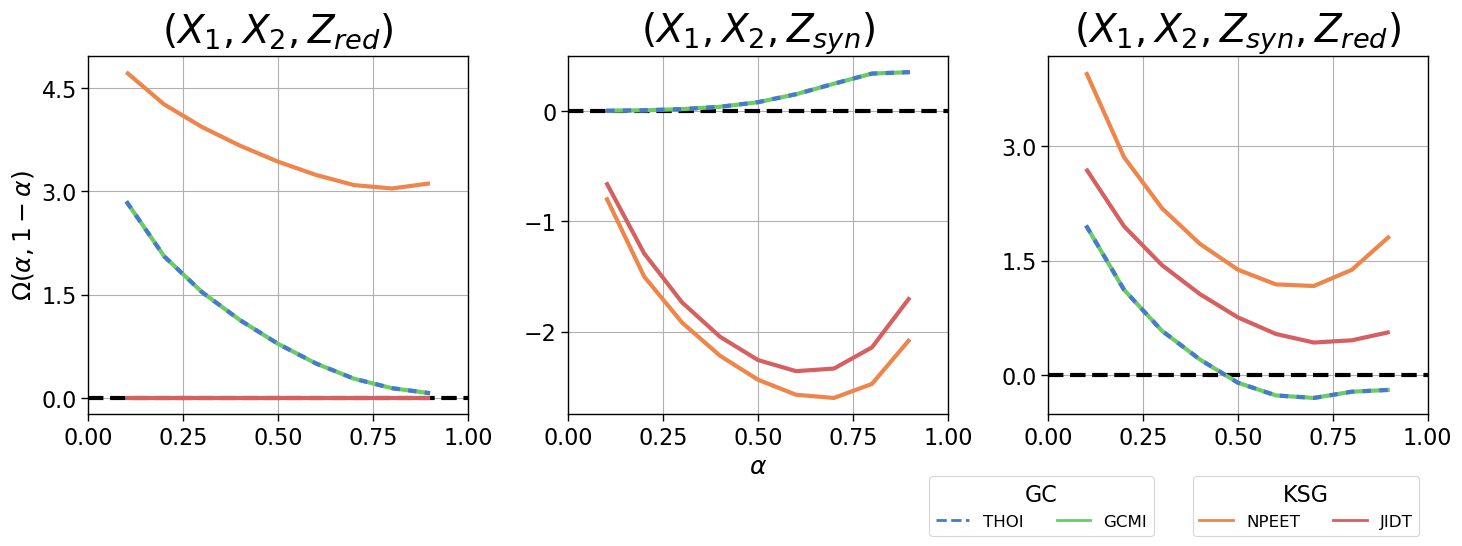

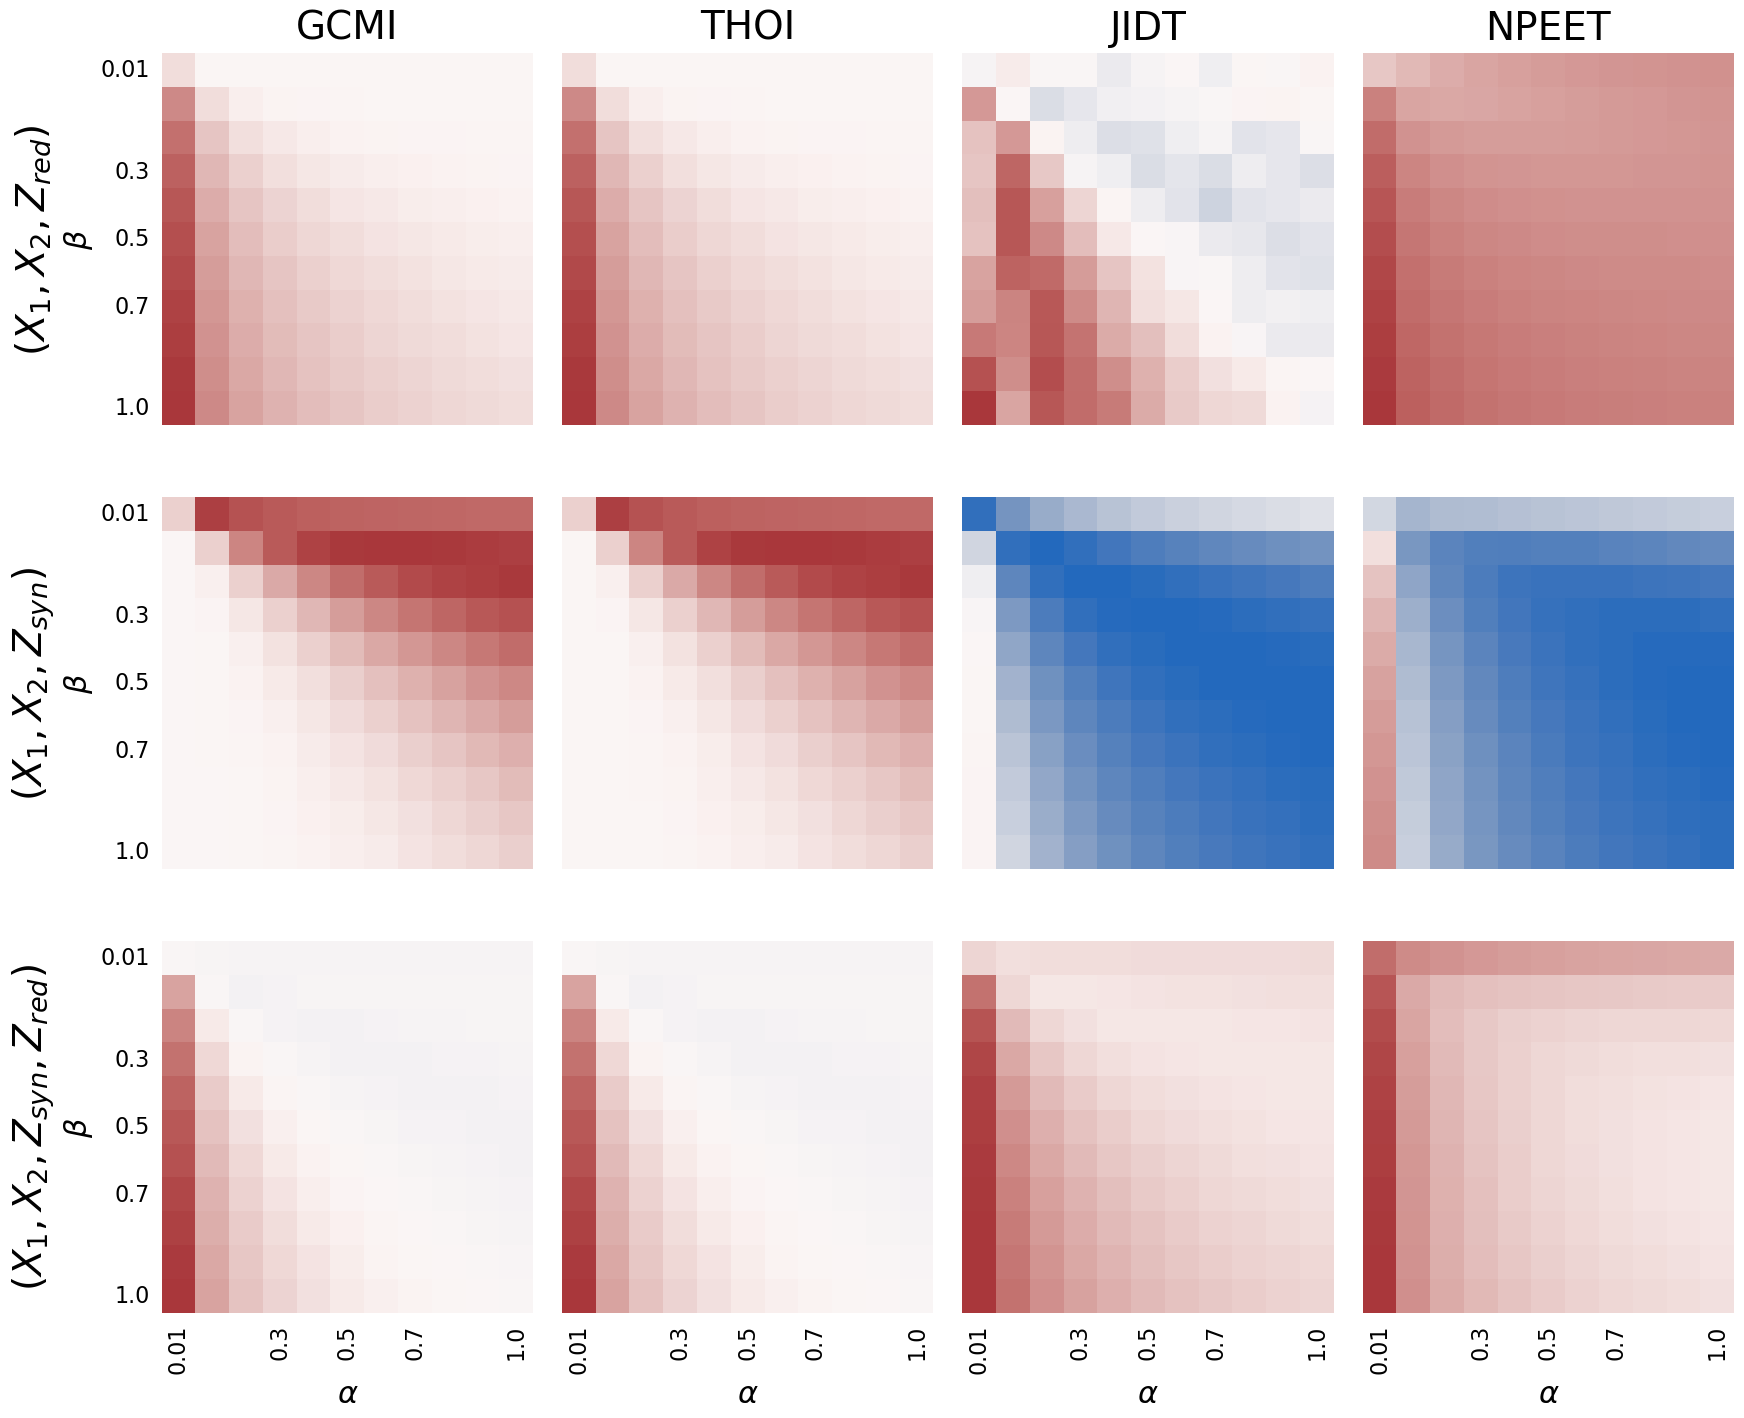

In [7]:
df = read_csv('../benchmarking/results/o_info/system-relu_pow-0.5_repeat-20_t-10000')

plot_o_info_linear(df, 'relu_pow-0.5')
plot_o_info_heatmap(df, 'relu_pow-0.5')

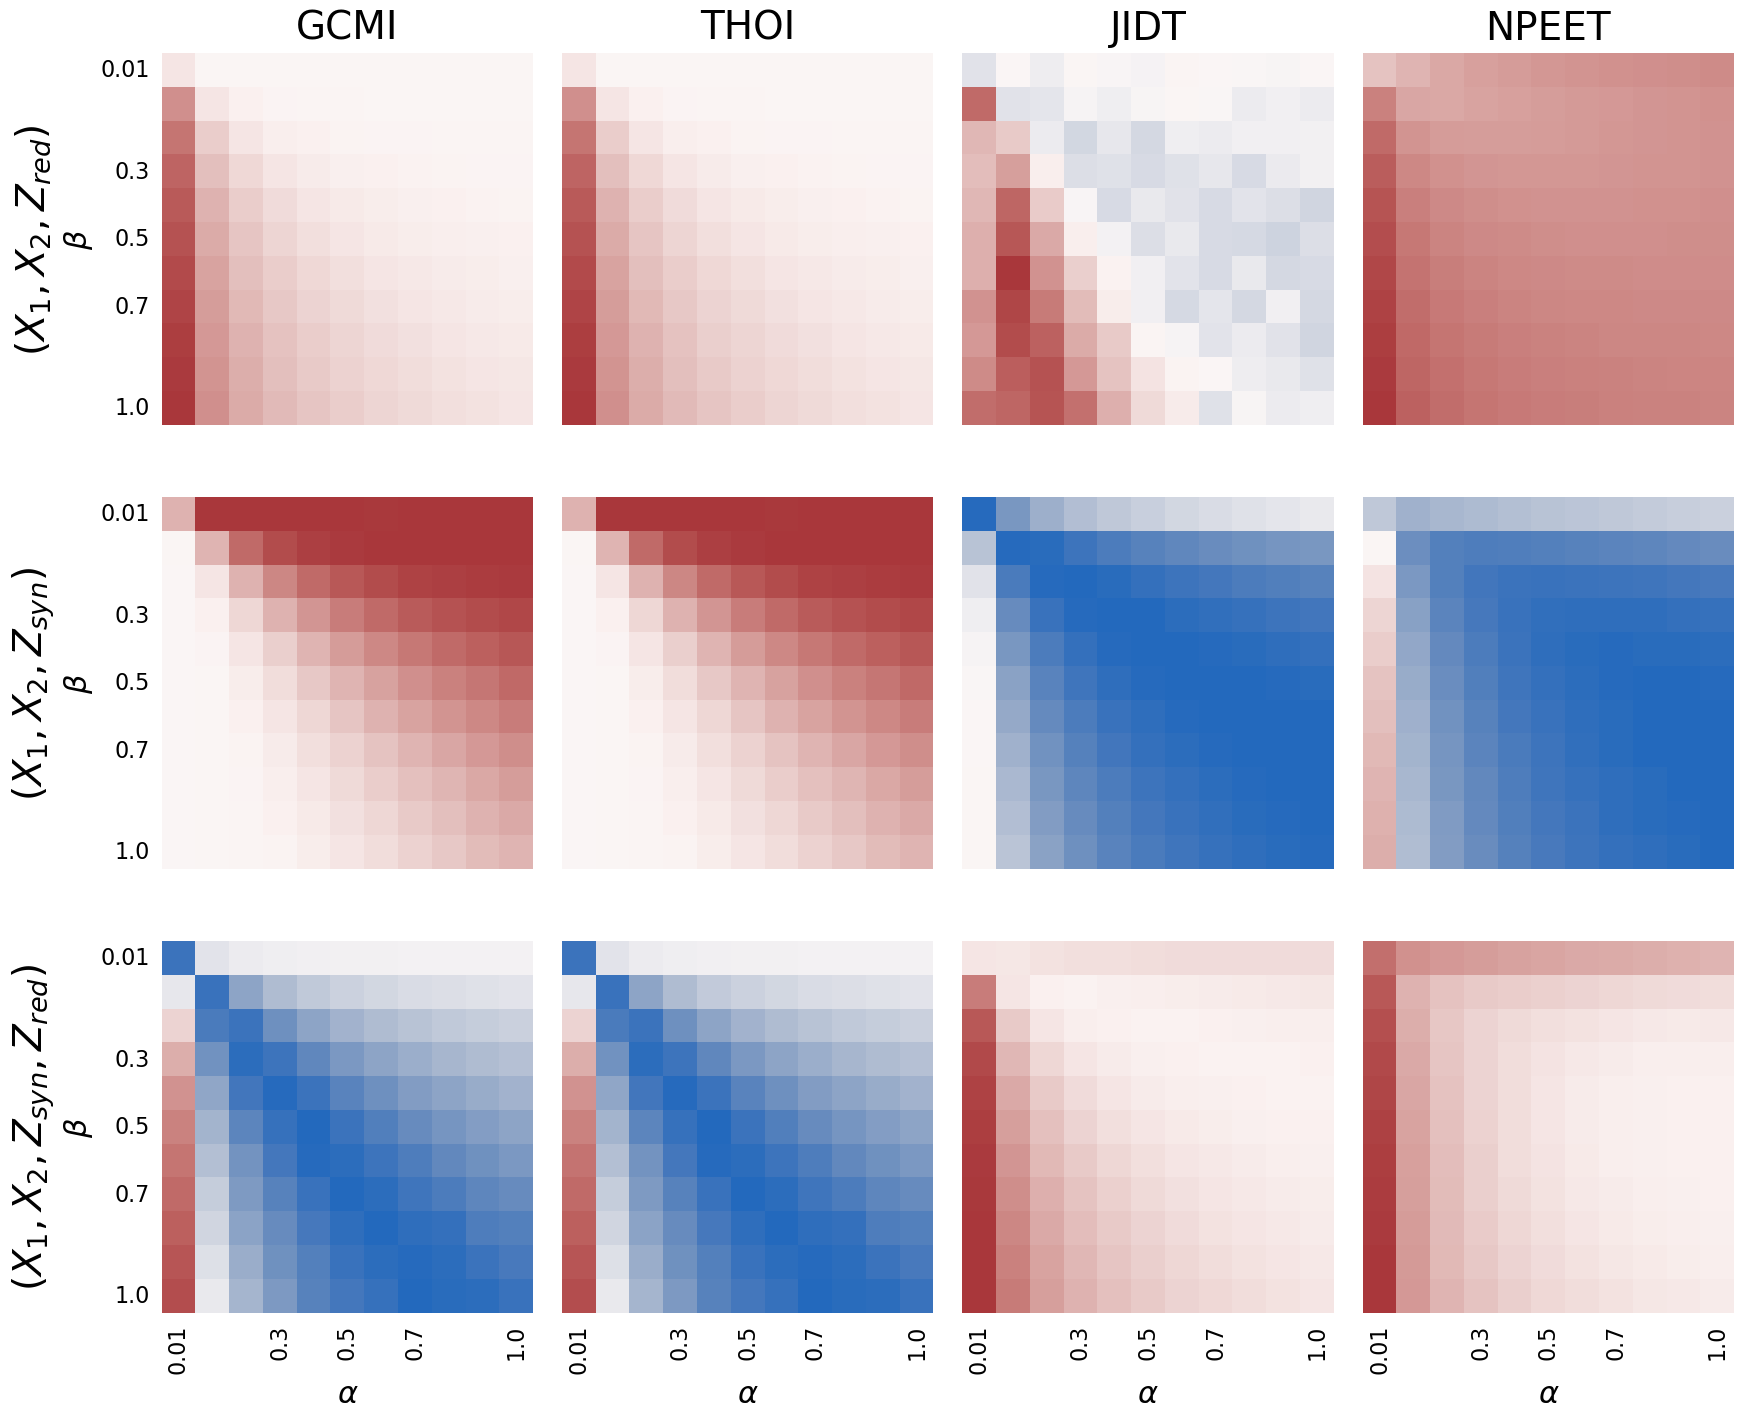

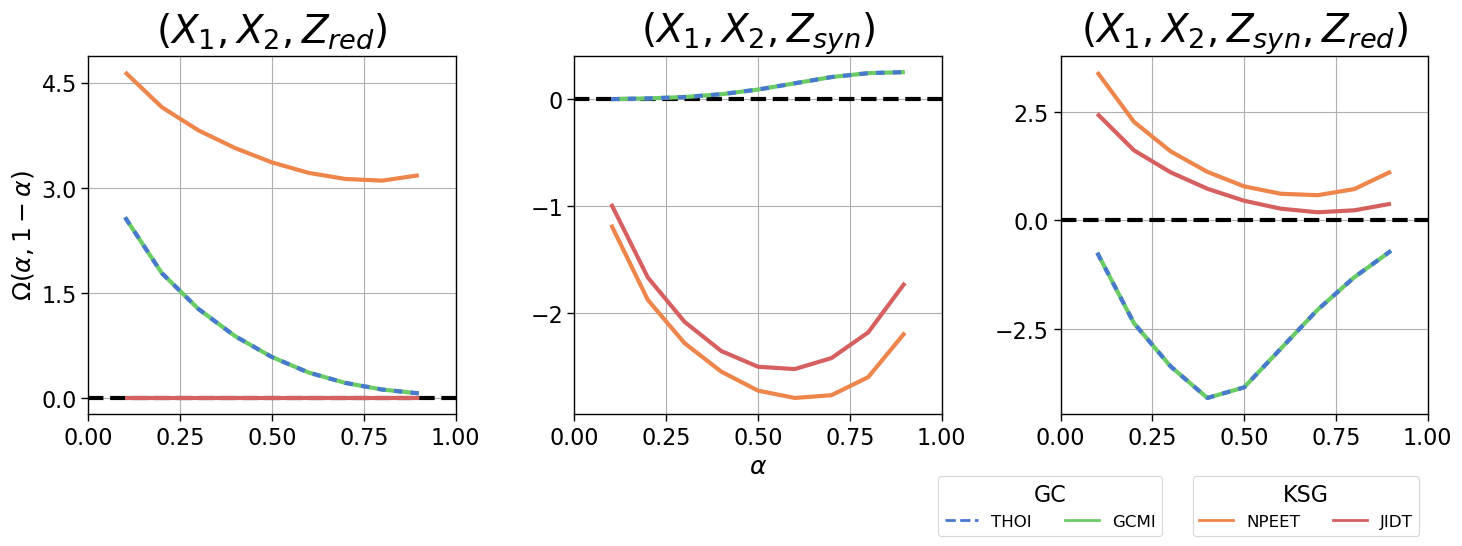

In [8]:
df = read_csv('../benchmarking/results/o_info/system-relu_pow-1.0_repeat-20_t-10000')

plot_o_info_heatmap(df, 'relu_pow-1.0|')
plot_o_info_linear(df, 'relu_pow-1.0')

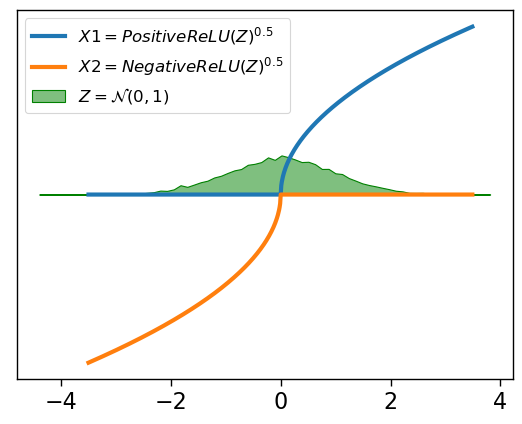

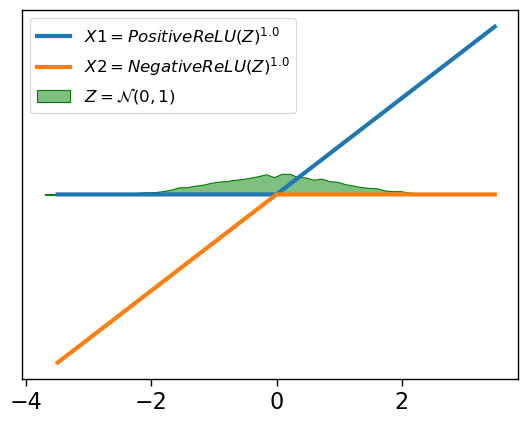

In [7]:
def ReLU(X, cutoff=0):
    return np.maximum(X,cutoff)


def plot_ReLU_system(pow_factor=0.5, ax=None):

    Z = np.arange(-3.5, 3.5, 0.01)
    X1 = np.power(ReLU(Z), pow_factor)
    X2 = -np.power(np.abs(ReLU(-Z)), pow_factor)


    ax = sns.histplot(np.random.normal(0,1,10000), stat='density', element='poly', color='green', alpha=0.5, label=r'$Z = \mathcal{N}(0,1)$', ax=ax)
    sns.lineplot(x=Z, y=X1, label=rf'$X1 = PositiveReLU(Z)^{{ {pow_factor} }}$', ax=ax)
    sns.lineplot(x=Z, y=X2, label=rf'$X2 = NegativeReLU(Z)^{{ {pow_factor} }}$', ax=ax)

    ax.set_ylabel('')
    ax.set_yticks([])


plot_ReLU_system(pow_factor=0.5)
plt.savefig('./figures/systems/system-ReLU_power-0.5.pdf', format='pdf')
plt.show()

plot_ReLU_system(pow_factor=1.0)
plt.savefig('./figures/systems/system-ReLU_power-1.0.pdf', format='pdf')
plt.show()

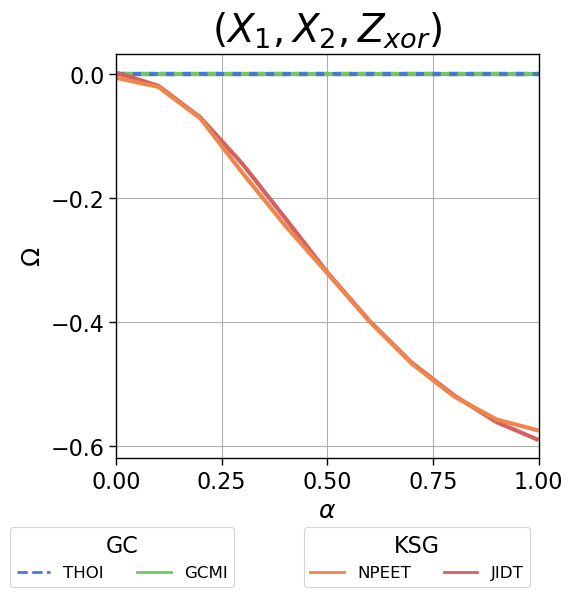

In [7]:
df = read_csv('../benchmarking/results/o_info/system-xor_repeat-20_t-10000')

plot_o_info_linear(df, 'xor', remove_beta=False, figsize=(6,6.5), ylabel=r'$\Omega$')

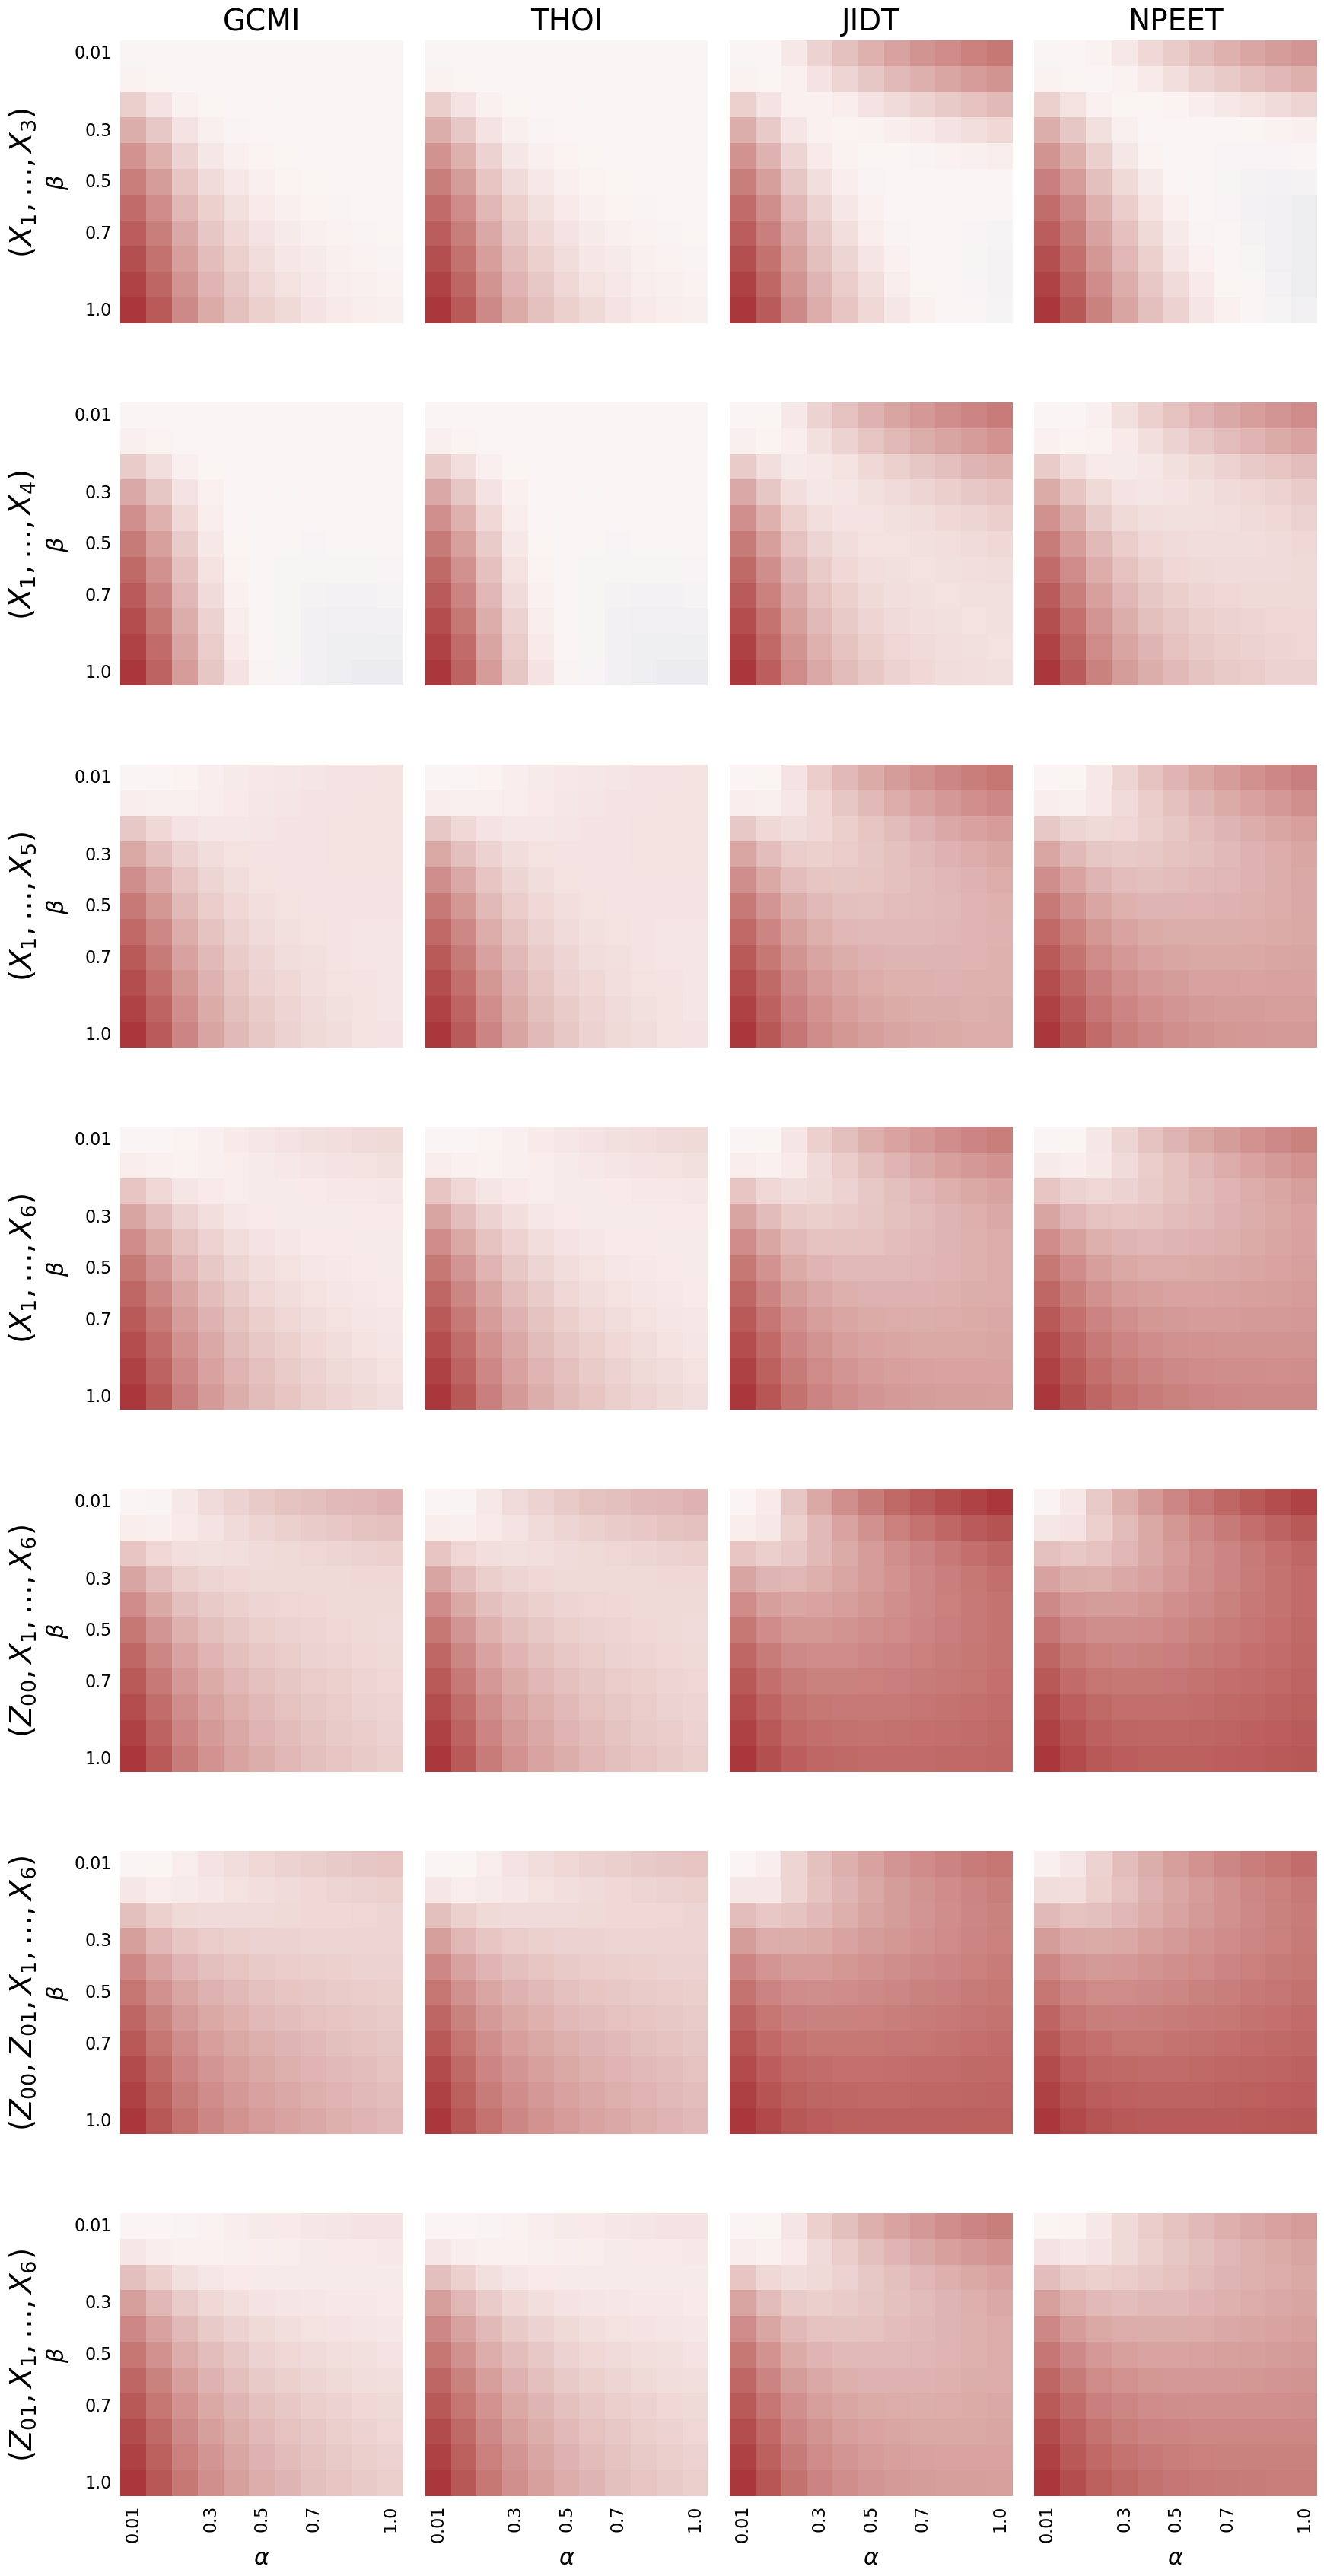

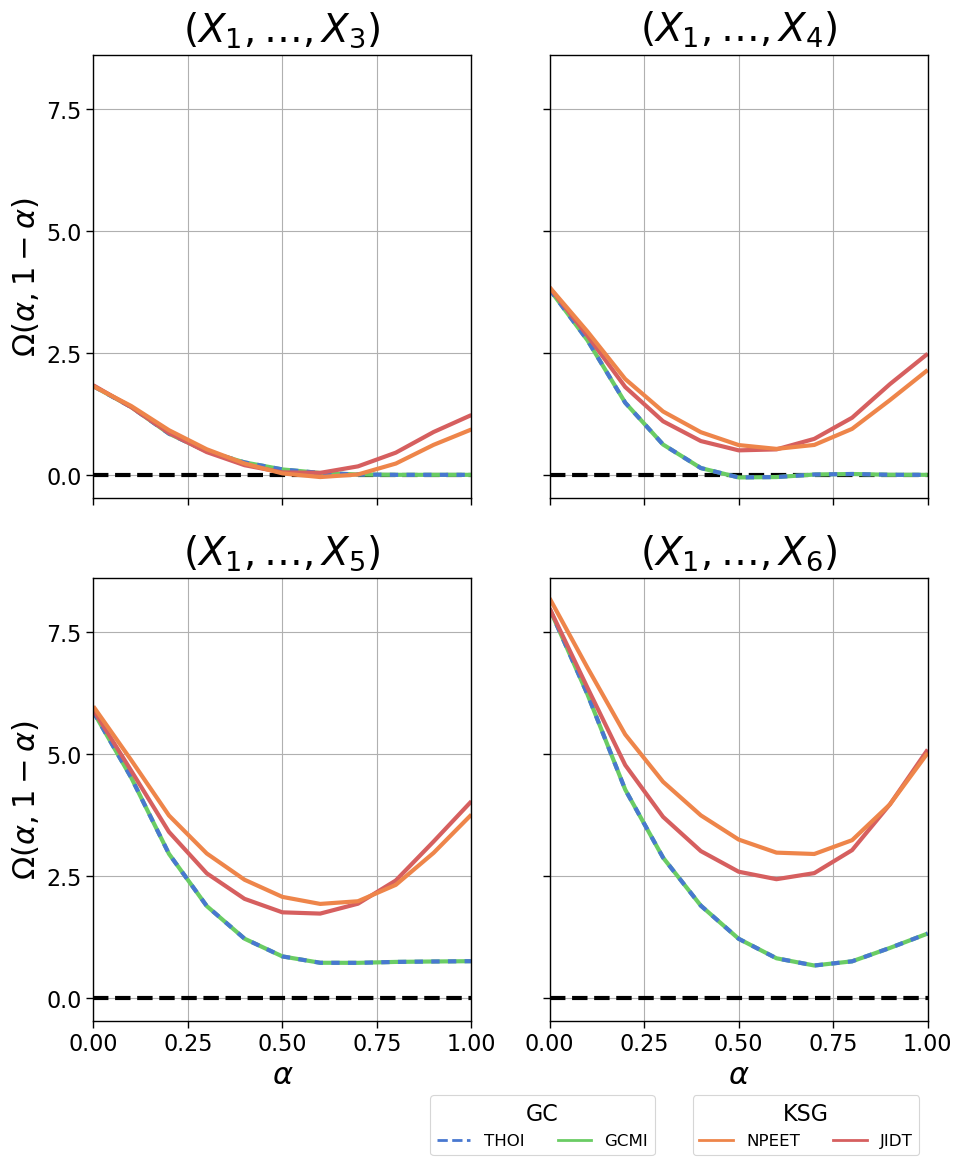

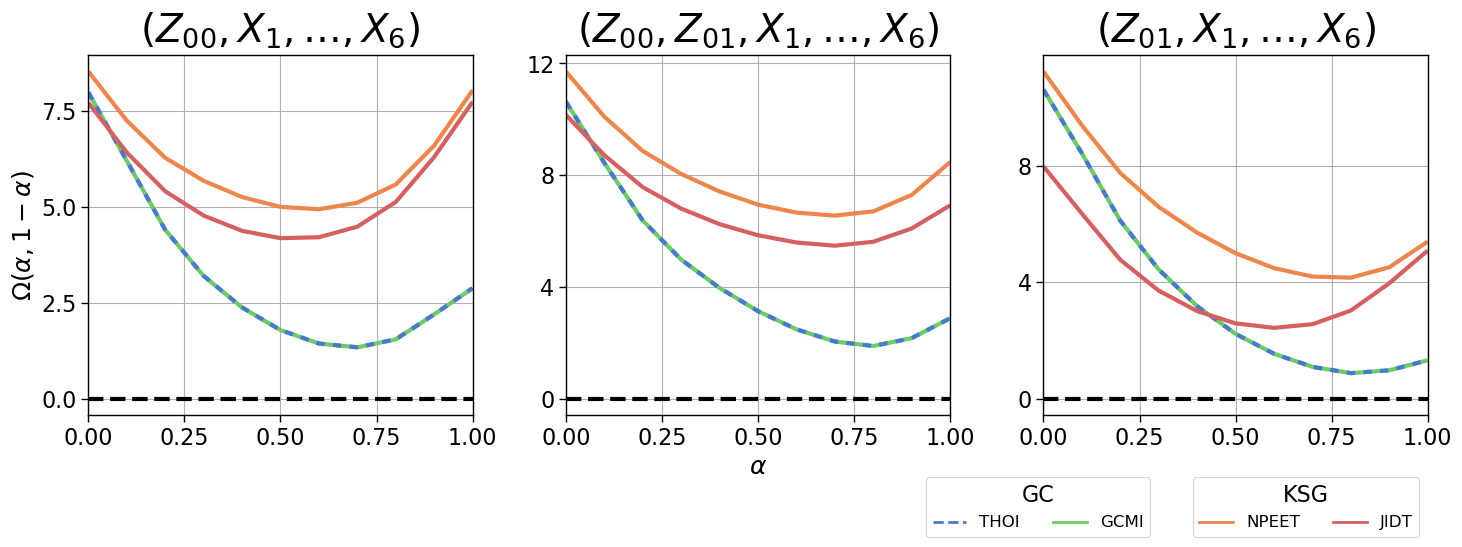

In [10]:
nplets = ['X1-X2-X3','X1-X2-X3-X4','X1-X2-X3-X4-X5','X1-X2-X3-X4-X5-X6','Z01-X1-X2-X3-X4-X5-X6','Z00-X1-X2-X3-X4-X5-X6','Z00-Z01-X1-X2-X3-X4-X5-X6']

df = read_csv('../benchmarking/results/o_info/system-flat_repeat-20_t-10000')

df = df[df.gamma == 0.1]
df = df[df['n-plet'].isin(nplets)]

#df = df[(df['beta'] >= 0.095) & (df['beta'] <= 0.905) & (df['alpha'] >= 0.095) & (df['alpha'] <= 0.905)]

plot_o_info_heatmap(df, 'flat')

nplets = ['X1-X2-X3','X1-X2-X3-X4','X1-X2-X3-X4-X5','X1-X2-X3-X4-X5-X6']
fig_width = 10.0
fig_height = 12.0
fig, axes = plt.subplots(2, 2, figsize=(fig_width, fig_height), sharex=True, sharey=True)
plot_o_info_linear(df[df['n-plet'].isin(nplets)],'flat_xvars', axes=axes)

nplets = ['Z01-X1-X2-X3-X4-X5-X6','Z00-X1-X2-X3-X4-X5-X6','Z00-Z01-X1-X2-X3-X4-X5-X6']
plot_o_info_linear(df[df['n-plet'].isin(nplets)],'flat_allvars')

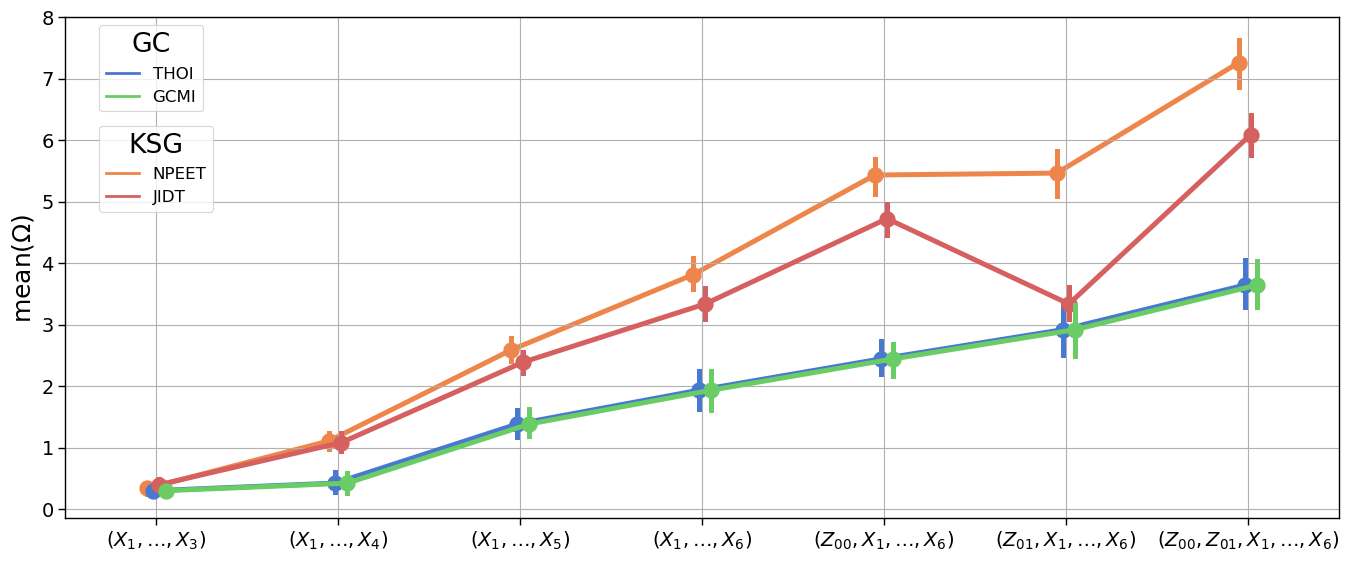

In [11]:
rcParams = {
    'xtick.labelsize': 12,
    'axes.titlesize': 28,
    'axes.labelsize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 12,
    'lines.linewidth': 2
}
sns.set_context("paper", font_scale=2, rc=rcParams)

nplet_order = [
    'X1-X2-X3',
    'X1-X2-X3-X4',
    'X1-X2-X3-X4-X5',
    'X1-X2-X3-X4-X5-X6',
    'Z00-X1-X2-X3-X4-X5-X6',
    'Z01-X1-X2-X3-X4-X5-X6',
    'Z00-Z01-X1-X2-X3-X4-X5-X6'
]

plt.figure(figsize=(14, 6))
sns.pointplot(
    data=df, x='n-plet', y='O-information', hue='method',
    palette=method_colors, order=nplet_order,
    dodge=True, join=True, markers='o'
)

# Customize the plot
plt.xticks([0,1,2,3,4,5,6], [nplet_labels[nplet] for nplet in nplet_order])
plt.xlabel('')

plt.ylabel(r'mean($\Omega$)')
plt.title('')

legend_elements_gaussian = [
    Line2D([0], [0], color=method_colors['THOI'], lw=2, label='THOI'),
    Line2D([0], [0], color=method_colors['GCMI'], lw=2, label='GCMI')
]
legend_elements_kl = [
    Line2D([0], [0], color=method_colors['NPEET'], lw=2, label='NPEET'),
    Line2D([0], [0], color=method_colors['JIDT'], lw=2, label='JIDT')
]

l1 = plt.legend(handles=legend_elements_gaussian, title='GC', loc='upper left', bbox_to_anchor=(0.02, 1))
plt.gca().add_artist(l1)
plt.legend(handles=legend_elements_kl, title='KSG', loc='upper left', bbox_to_anchor=(0.02, 0.8))
    
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.savefig('./figures/o_info/system-flat_mean_per_nplet_and_method.pdf', format='pdf')
plt.show()